# Behaviour analyse from seabird acceleration records

This notebook explores the behaviour analysis and tools for acceleration data based on streaked shearwater records (details can be found in [the original paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0254454#:~:text=predators%20%7C%20PLOS%20ONE-,Video%20and%20acceleration%20records%20of%20streaked%20shearwaters%20allows%20detection%20of,associated%20with%20large%20marine%20predators)). Data from DVL video and acceleration records are used for demonstration and validation purposes, though the method is designed to be used on any acceleration records, and will be applied to acceleration and GPS records from AxyTrek tags.

In [1]:
from pathlib import Path
# bring in functions from main_func
from src.main_func import *
from math import pi
from scipy.signal import find_peaks
from scipy import stats
from src.birdTag import birdTag

import pandas as pd
import regex as re
import glob, platform

# parent folder for all DVL data
if platform == 'darwin':
    dvlFolders = "/Users/aran/Documents/DVL/"
else:
    dvlFolders = "H:/My Drive/Data/DVL/"

## Behaviour analysis process

We'll run through some of the base functionality here. First, the data must be read in:

In [2]:
# acc and vid starttimes
st17008 = [pd.to_datetime('31/08/2018 06:00:00', format = "%d/%m/%Y %H:%M:%S"),
           pd.to_datetime('31/08/2018 12:00:00', format = "%d/%m/%Y %H:%M:%S")]
st18012 = [pd.to_datetime('31/08/2018 04:00:00', format = "%d/%m/%Y %H:%M:%S"),
            pd.to_datetime('31/08/2018 10:00:00', format = "%d/%m/%Y %H:%M:%S")]
st18014 = [pd.to_datetime('31/08/2018 06:00:00', format = "%d/%m/%Y %H:%M:%S"),
            pd.to_datetime('31/08/2018 12:00:00', format = "%d/%m/%Y %H:%M:%S")]
st18017 = [pd.to_datetime('31/08/2018 04:00:00', format = "%d/%m/%Y %H:%M:%S"),
            pd.to_datetime('31/08/2018 11:00:00', format = "%d/%m/%Y %H:%M:%S")]
st18018 = [pd.to_datetime('31/08/2018 04:00:00', format = "%d/%m/%Y %H:%M:%S"),
            pd.to_datetime('31/08/2018 12:00:00', format = "%d/%m/%Y %H:%M:%S")]
starttimes = [st17008,st18012,st18014,st18017,st18018]

tagnames = ['17008','18012','18014','18017','18018']

# dictionaries storing start times (acceleration [0], video [1])
tagInfo = dict(zip(tagnames,starttimes))

# initialise dictionary
tagData = {}

# read in the video behaviour records
if platform.system() != 'Darwin':
    behav_class_loc = 'H:/My Drive/Data/DVL/DiveBehavClass.csv'
else:
    behav_class_loc = '/Users/aran/Library/CloudStorage/GoogleDrive-aran.garrod@googlemail.com/My Drive/Data/DVL/DiveBehavClass.csv'
behavClass = pd.read_csv(behav_class_loc, sep = ',', usecols = [0,1,2,4], dtype = {'Tag' : str})

# replace 'Dive' behaviour with 's' (surface) or 'd' (dive)
behavClass.loc[behavClass['Behaviour'] == 'Dive','Behaviour'] = behavClass.loc[behavClass.Behaviour == 'Dive','ForageBeh']
# remove superfluous column
behavClass.drop('ForageBeh',axis = 1, inplace = True)

# set time to datetime
behavClass.Time = pd.to_datetime('31/08/2018 ' + behavClass.Time, format = '%d/%m/%Y %H.%M.%S.%f')


# path=Path(dvlFolders+"/18012/acc-video-2018-18012.txt")

for path in Path(dvlFolders).rglob('*acc*.txt'):
    
    print(f"Reading in acceleration data")
    # read in acceleration data
    dat = pd.read_table(path.__str__(), skiprows = 7, sep = ',', usecols = [0,1,2])

    # remove whitespace from headers
    dat.rename(columns=lambda x: x.strip(), inplace = True)

    # add time series
    dat['DT'] = pd.date_range(tagInfo[re.search(r"(\d{5}?).txt",path.name).group(1)][0], periods = len(dat), freq = '50ms')

    # select data within video range
    dat = dat[(dat.DT >= tagInfo[re.search(r"(\d{5}?).txt",path.name).group(1)][1]) & (dat.DT < tagInfo[re.search(r"(\d{5}?).txt",path.name).group(1)][1] + pd.Timedelta(hours=2))]

    # calculate pitch (clip array to min max of -1 1, assumes acceleration measured in g)
    print(f"Calculating acceleration features")
    dat = pd.concat([dat.reset_index(), accFeatures(dat[['X','Y','Z']],['Y','Z','X'],1.5,3,20)], axis = 1)
    tagname=re.search(r"(\d{5}?).txt",path.name).group(1)

    # generate spectrogram and summed spectral energy difference
    print(f"Generating spectrogram and spectral energy sums")
    f,s,Sxx = hammingSpect(dat.Z, fs = 20)
    rollSum = rollingSpecSum(Sxx, f, 3, 5, fs = 20)
    print(f"Performing roll sum")

    # extract behaviours for the specific tag
    bc = behavClass[behavClass.Tag == re.search(r"(\d{5}?).txt",path.name).group(1)]
    print(f"Popping behaviour classes")

    # remove minute containing AT behaviour
    print(f"Removing erroneous behaviour periods")
    if bc.Behaviour.eq('AT').any():
        print(f"AT present")
        behAT = np.any([(dat.DT >= (x - pd.Timedelta(30,'sec'))) & (dat.DT <= (x + pd.Timedelta(30,'sec'))) for x in bc.Time[bc.index[bc.Behaviour == 'AT']].round("s").values], axis = 0)

        rollSum[behAT[(2*20):-(2*20)+1]] = min(rollSum)
    
    print(f"Calculating {10} flight periods")

    flight_inds = maxWithGap(rollSum,20,numPoints=10)

    tagData[re.search(r"(\d{5}?).txt",path.name).group(1)] = {'acc' : dat, 'beh' : bc, 'fl_inds': flight_inds}

# returns dictionary for each tag, each contain two keys, 'acc' for acceleration data, 'beh' for video-derived behaviours. Data should be aligned.

# maxWithGap(rollSum,20,numPoints=10)



Reading in acceleration data
Calculating acceleration features
Generating spectrogram and spectral energy sums
Performing roll sum
Popping behaviour classes
Removing erroneous behaviour periods
AT present
Calculating 10 flight periods
Reading in acceleration data
Calculating acceleration features
Generating spectrogram and spectral energy sums
Performing roll sum
Popping behaviour classes
Removing erroneous behaviour periods
AT present
Calculating 10 flight periods
Reading in acceleration data
Calculating acceleration features
Generating spectrogram and spectral energy sums
Performing roll sum
Popping behaviour classes
Removing erroneous behaviour periods
AT present
Calculating 10 flight periods
Reading in acceleration data
Calculating acceleration features
Generating spectrogram and spectral energy sums
Performing roll sum
Popping behaviour classes
Removing erroneous behaviour periods
AT present
Calculating 10 flight periods
Reading in acceleration data
Calculating acceleration featur

### Identifying flapping

We use the doresoventral acceleration signal to identify flapping vs gliding/other behaviours. This signal, shown below, contains large changes in magnitude when the bird performs up or down strokes, with smaller changes during period of gliding. We will use this characteristic to isolate flapping signals.

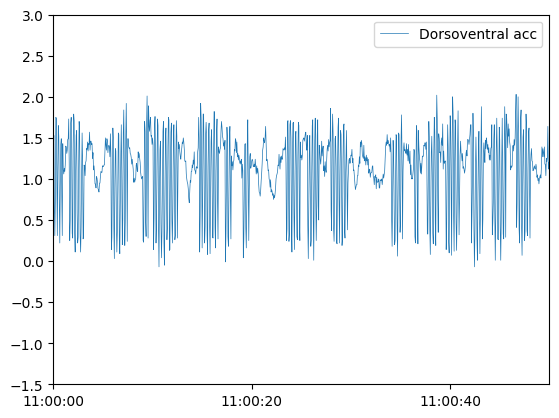

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

xformatter = mdates.DateFormatter('%H:%M:%S')
plt.plot(tagData['18017']['acc'].DT.values,tagData['18017']['acc'].Z.values,label='Dorsoventral acc',linewidth=.5)
plt.legend()
plt.xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000])
plt.ylim(-1.5,3)
plt.xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000],np.timedelta64(20,'s')),unit='s'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

### Isolating signal extrema

Simply finding the peaks and troughs is trivial, shown below, but now flapping vs gliding signals must be separated.

In [4]:
sig = tagData['18017']['acc'].Z
peaks,_ = find_peaks(sig)
troughs,_ = find_peaks(-sig)

if peaks[0] > troughs[0]:
    peaks.pop(0)
if peaks[-1] > troughs[-1]:
    peaks.pop(-1)

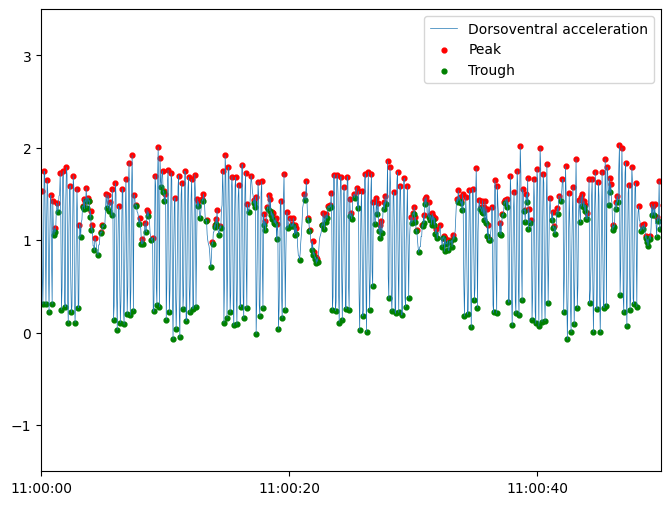

In [5]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(tagData['18017']['acc'].DT.values,tagData['18017']['acc'].Z.values,label='Dorsoventral acceleration',linewidth=.5)
ax.scatter(tagData['18017']['acc'].DT[peaks],sig[peaks],c='r',label='Peak',s=12)
ax.scatter(tagData['18017']['acc'].DT[troughs],sig[troughs],c='g',label='Trough',s=12)
ax.legend()
ax.set_xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000])
ax.set_ylim(-1.5,3.5)
ax.set_xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000],np.timedelta64(20,'s')),unit='s'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

### Using densities

If we take magnitude differences across peaks and troughs, we can generated a density estimate of this magnitude. We expect two peaks,representing the typical magnitude change during flapping (higher) vs gliding (lower). Assuming these represent typical magnitude changes between the two behaviours, we take the trough found between these two peaks, the inter-peak trough, as the treshold for a dorsoventral acceleration magnitude change that indicates a flap vs a glide:

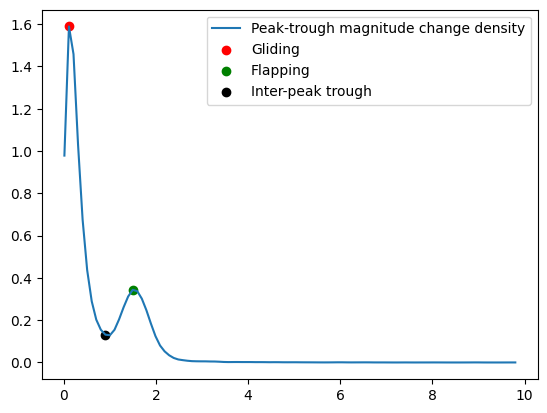

In [6]:
data = sig[peaks].values - sig[troughs].values
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

ppeaks,_ = find_peaks(p)

# take first two peaks and find the trough inbetween
pks,_ = find_peaks(-p[ppeaks[0]:ppeaks[1]])

# retain only sufficiently large z displacements
large_inds = (sig[peaks].values - sig[troughs].values) > x[pks]

plt.plot(x,p,label='Peak-trough magnitude change density')
plt.scatter(x[ppeaks[0]],p[ppeaks[0]],c='r',label='Gliding')
plt.scatter(x[ppeaks[1]],p[ppeaks[1]],c='g',label='Flapping')
plt.scatter(x[pks],p[pks],c='k',label='Inter-peak trough')
plt.legend()

Sticking all this together, we now only keep peaks and troughs where the magnitude change exceeds this inter-peak trough, and this gives us a decent indication of when the bird was flapping, the number of times, how often etc.

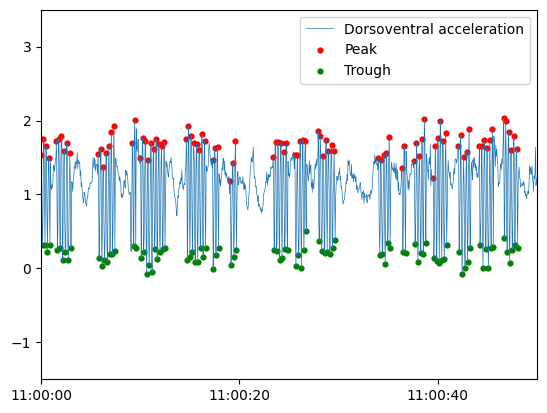

In [7]:
plt.plot(tagData['18017']['acc'].DT.values,tagData['18017']['acc'].Z.values,label='Dorsoventral acceleration',linewidth=.5)
plt.scatter(tagData['18017']['acc'].DT[peaks[large_inds]],sig[peaks[large_inds]],c='r',label='Peak',s=12)
plt.scatter(tagData['18017']['acc'].DT[troughs[large_inds]],sig[troughs[large_inds]],c='g',label='Trough',s=12)
plt.legend()
plt.xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000])
plt.ylim(-1.5,3.5)
plt.xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000],np.timedelta64(20,'s')),unit='s'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

### Flapping bouts

Finally, we can start grouping the flapping points together using prior knowledge about streaked shearwater typical flapping frequencies. Assume that birds will not flap outside of this 

In [8]:
flapInds = np.sort(np.concatenate([peaks[large_inds],troughs[large_inds]]))

flap_gap = np.array([x-y for x,y in zip(flapInds[1:],flapInds)]) > (2*20/4)

flapInds[1:][flap_gap]

flapInds[29:33]
flapInds[1:10]


from itertools import compress
separators = np.array(list(compress(range(len(flap_gap)),flap_gap)))

# flapInds[0:9]

flap_mask = np.zeros(len(sig))
for x in range(len(separators)):
    if x == 0:
        flap_mask[flapInds[0]:separators[0]] = 1
    elif x < len(separators):
        flap_mask[flapInds[separators[x-1]:separators[x]]] = 1
# add final segment
flap_mask[flapInds[flapInds > flapInds[separators[-1]]][0]:flapInds[flapInds > flapInds[separators[-1]]][-1]] = 1

This whole sequence of calculations are put together in the `flap` and `find_gaps` functions:

In [9]:
def find_gaps(signal, gap_size):
    """Identify gaps in bool array `signal` greater than `gap_size` in length. Extend True segments to contain all elements contained within gap.

    Returns bool array with fully extended True bouts.
    """
    past_threshold = np.array([x-y for x, y in zip(signal[1:],signal)]) > gap_size
    past_threshold = np.array(list(compress(range(len(past_threshold)),past_threshold)))
    # ends = past_threshold.append(len(flapInds))
    ends = np.append(past_threshold,(len(signal)-1))
    starts = np.insert(past_threshold + 1,0,0)
    # mask = np.zeros(ends[-1]).astype(int)
    # for x,y in zip(starts,ends):
    #     mask[x:y] = 1
    return signal[starts],signal[ends]

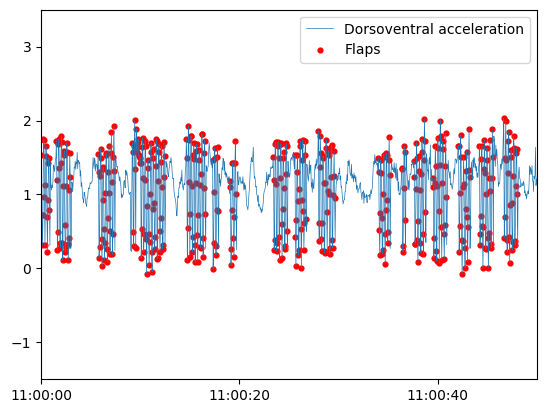

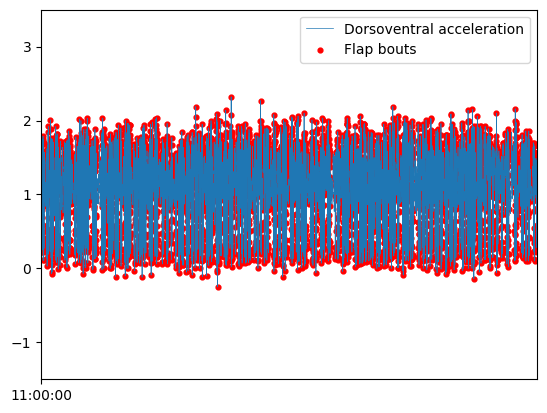

In [10]:
flap_mask, flap_bouts = flap(tagData['18017']['acc'].Z, fs=20, bout_gap=5, flap_freq=4)

plt.figure()
plt.plot(tagData['18017']['acc'].DT.values,tagData['18017']['acc'].Z.values,label='Dorsoventral acceleration',linewidth=.5)
plt.scatter(tagData['18017']['acc'].DT[flap_mask==1],sig[flap_mask==1],c='r',label='Flaps',s=12)
plt.legend()
plt.xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000])
plt.ylim(-1.5,3.5)
plt.xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000],np.timedelta64(20,'s')),unit='s'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

plt.figure()
plt.plot(tagData['18017']['acc'].DT.values,tagData['18017']['acc'].Z.values,label='Dorsoventral acceleration',linewidth=.5)
plt.scatter(tagData['18017']['acc'].DT[flap_bouts==1],sig[flap_bouts==1],c='r',label='Flap bouts',s=12)
plt.legend()
plt.xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[10000])
plt.ylim(-1.5,3.5)
plt.xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[10000],np.timedelta64(20,'m')),unit='m'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

## birdTag class

The new class, `birdTag`, incorporates the various methods required for reading in, formatting, and analysing data from DVL, AxyTrek, and BiP sources. The class utilises a number of utility functions from the `DVLUtils`, `loadIn`, `analyseAcc`, and `analyseGPS` scripts. Below will be a short demonstration of the class' utility and process for analysing behaviour from acceleration records. This will use DVL data, as this is our ground truthing data.

N.B. the DVL data provided not only includes the tag recordings, but also some behaviour classifications from concurrent video recordings (the 'ground truth').

First, we define some file paths, specifically the directory of the DVL tag data (`dvlFolders`), where data is structured as such:

```bash
DVL
│  
└───tag1
│   │   tag1_acceleration.txt
│   │
└───tag2
│   │   tag2_acceleration.txt
```

In [11]:
# read in the video behaviour records
if platform.system() == 'Darwin':
    behav_class_loc = '/Users/aran/Library/CloudStorage/GoogleDrive-aran.garrod@googlemail.com/My Drive/Data/DVL/DiveBehavClass.csv'
else:
    behav_class_loc = 'H:/My Drive/Data/DVL/DiveBehavClass.csv'

accFiles = glob.glob(dvlFolders + '*/*acc*.txt')

### DVL configs
A list of file config dictionaries is then generated, with each tag's name, the start time for acceleration recordings, and a start time for video recordings. This is specific to DVL tags.

In [12]:
tags = [
    {'name':'17008','accSt':'31/08/2018 06:00:00','vidSt':'31/08/2018 12:00:00'},
    {'name':'18012','accSt':'31/08/2018 04:00:00','vidSt':'31/08/2018 10:00:00'},
    {'name':'18014','accSt':'31/08/2018 06:00:00','vidSt':'31/08/2018 12:00:00'},
    {'name':'18017','accSt':'31/08/2018 04:00:00','vidSt':'31/08/2018 11:00:00'},
    {'name':'18018','accSt':'31/08/2018 04:00:00','vidSt':'31/08/2018 12:00:00'}
]

A `birdTag` object is then generated for each tag, giving as arguments:
* the filename of the acceleration data
* the type of tag (case-insensitive)
* the name of the tag
* the acceleration sampling frequency
* the corresponding column names for longitudinal, dorsoventral (vertical), and lateral axes **this order is important**
* the GPS fixes per minute (can be set to `None`)
* the acceleration start time
* the video start time

For different tag types, some of these arguments are optional (e.g. for DVL tags, `gps_fixes_per_minute` is not required).

In [13]:
dvls = [birdTag(**{
    'filepath': fname,
    'tag_type': 'dvl',
    'tagname': tags[i]['name'],
    'accfs': 20,
    'long_acc_name': ['Y','Z','X'],
    'gps_fixes_per_minute': None,
    'accStart': tags[i]['accSt'],
    'vidStart': tags[i]['vidSt']
    }) for i,fname in enumerate(accFiles)
    ]

Now we can show some simple information for each tag, e.g. their names:

In [14]:
for idx,tag in enumerate(dvls):
    print(f"Tag {idx+1} name: {tag.tagname}")
    print(f"Acceleration start time: {tag.accStart}")
    print(f"Video start time: {tag.vidStart}")
    print("--------------------------------")

Tag 1 name: 17008
Acceleration start time: 2018-08-31 06:00:00
Video start time: 2018-08-31 12:00:00
--------------------------------
Tag 2 name: 18012
Acceleration start time: 2018-08-31 04:00:00
Video start time: 2018-08-31 10:00:00
--------------------------------
Tag 3 name: 18014
Acceleration start time: 2018-08-31 06:00:00
Video start time: 2018-08-31 12:00:00
--------------------------------
Tag 4 name: 18017
Acceleration start time: 2018-08-31 04:00:00
Video start time: 2018-08-31 11:00:00
--------------------------------
Tag 5 name: 18018
Acceleration start time: 2018-08-31 04:00:00
Video start time: 2018-08-31 12:00:00
--------------------------------


### birdTag acceleration utilities

There are currently a number of relatively useful tools to extract important metrics with the acceleration and GPS utilities, such as dynamic/static acceleration generation, GPS distance and speed calculations and filters. These will be correctly documented. For now, the static acceleration is extracted from acceleration signals using a lowpass equiripple filter (the same as the default filter in MATLAB), using a pass and stopband, between which the signal is reduced so as to prevent a hard stopping filter while diminishing the effects of higher frequency content in the resulting signal. Dynamic signals are produced from the difference of the original and static signals, and consequently pitch angles estimated as:
$$
\text{pitch} = \arcsin{x_{\text{static}}}
$$
where $x_{\text{static}}$ is the static longitudinal acceleration.

Further, FFT analysis of signal frequency content is achieved within the `hammingSpect` function, which can generate a spectrogram of a given signal. This is used to estimate flight periods from known flapping frequencies of streaked shearwaters. Some correction for unwanted behaviours (i.e. periods when birds pecked at DVL tags, resulting in erroneous signals) is performed during this stage, as it was in the original study. These functions can be adjusted for other tasks, e.g. isolating particular known behavioural signals.

There are a number of helpful tools within the class, primarily to help put together the behavioural algorithm, but also to help in plotting behaviours.

For now, we'll continue with the analysis of the 5 loaded DVL tags. These are the 5 tags from the 2018 field season. We have to read in the acceleration data and the corresponding video-recorded behaviour data. These are achieved using functions from the `loadIn` and `DVLutils` scripts.

Once data is read in, we can start to analyse and manipulate the present data. Firstly, the video-recorded behaviours are only assigned at their start times. Therefore, we must upsample this data to reflect the same sampling frequency as the acceleration data (to do like-for-like comparison).

We can then perform flight estimation and calculate flapping behaviours (as shown [above](#identifying-flapping)).

In [15]:
for x in dvls:
    print(f'Reading in {x.tagname} acc data...')
    x.readin(vidOnlyPeriod=True)
    print(f'Reading in {x.tagname} behaviours...')
    x.readBeh(behav_class_loc)
    print(f'Upsampling behaviour data...')
    x.upsample_behaviours()
    print('Calculating flight estimated periods...')
    x.flight_est(numPoints=10,removeErr=True)
    print('Calculating flapping periods')
    x.flapping()
    print('Calculateing flight pitch thresholds')
    x.calculate_thresholds()
    print(f"Tag {x.tagname} read in and analysis completed\n-------------------\n")

# calculate pitch differences for all tags
medianPitchChanges = []
for x in dvls:
    medianPitchChanges.append(x.calculate_thresholds())
from statistics import median
toEx = median(medianPitchChanges)

print("Ready to run behaviour detection")

Reading in 17008 acc data...
Reading in 17008 behaviours...
Upsampling behaviour data...
Calculating flight estimated periods...
Performing spectral rolling sum
Calculating flapping periods
Calculateing flight pitch thresholds
Tag 17008 read in and analysis completed
-------------------

Reading in 18012 acc data...
Reading in 18012 behaviours...
Upsampling behaviour data...
Calculating flight estimated periods...
Performing spectral rolling sum
Calculating flapping periods
Calculateing flight pitch thresholds
Tag 18012 read in and analysis completed
-------------------

Reading in 18014 acc data...
Reading in 18014 behaviours...
Upsampling behaviour data...
Calculating flight estimated periods...
Performing spectral rolling sum
Calculating flapping periods
Calculateing flight pitch thresholds
Tag 18014 read in and analysis completed
-------------------

Reading in 18017 acc data...
Reading in 18017 behaviours...
Upsampling behaviour data...
Calculating flight estimated periods...
Perf

### Running the behaviour detection method

Now we have the necessary data read in, calculated, and thresholds generated, we can run the `beh_detect` function. The output of this can be shown on the requested acceleration signal using `plot_acc_behaviours`. In this case, we'll use dynamic dorsoventral acceleration and provide some colour codes to plot each behaviour with (if no colours are provided, some distinct colours will be generated automatically). We can also overlay any video-detected foraging behaviour, which is shown by the black marks.

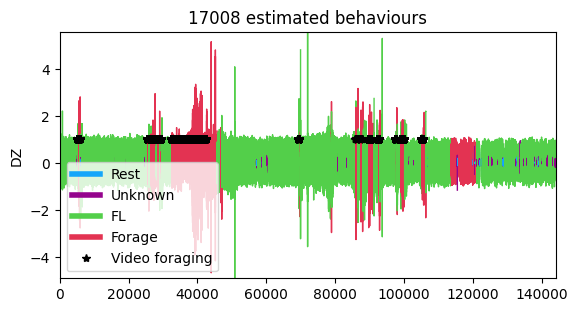

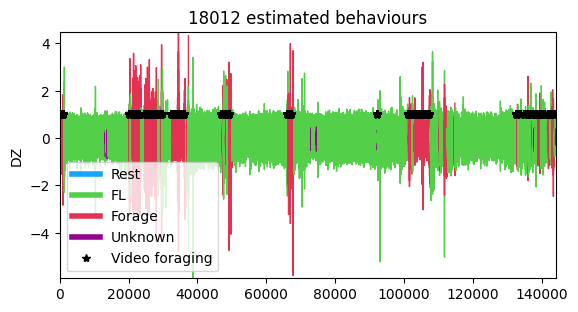

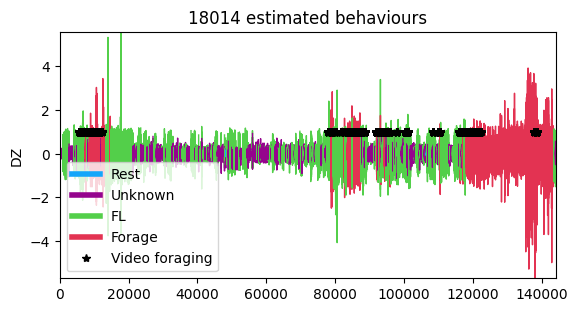

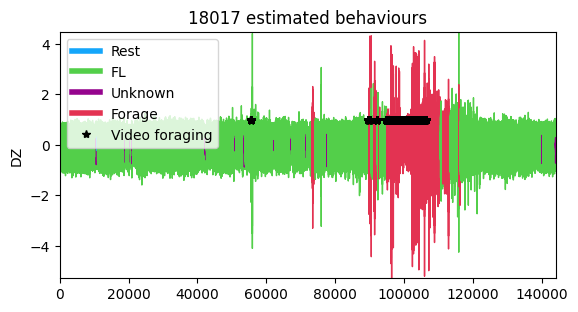

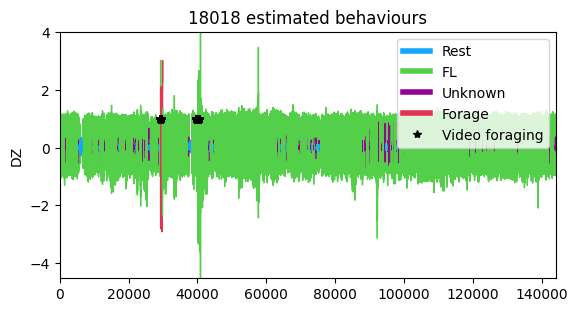

In [17]:
cols = [[0.325, 0.812, 0.29],[0.89, 0.2, 0.322],
    [0.078, 0.651, 0.98],[0.585,0.016,0.553]]
for d in dvls:
    d.beh_detect(toEx=toEx)
    d.plot_acc_behaviours('DZ',cols=cols,plot_vid_forage=True)

In these examples, the foraging detection does quite well, however, it misses some foraging segments, and incorrectly identifies some non-foraing periods. I believe the incorrectly classified periods are when the birds were pecking at the tag, and so generating strange signals that are causing the algorithm to incorrectly suggest foraging. The correct true/false positive rates will be calculated and added in to the birdTag system.

In [6]:
# signal = tagData['18017']['acc'].Z
# fs=20
# behav_data = tagData['18017']['beh']
# dt = tagData['18017']['acc'].DT

test,_ = flightestimate(tagData['18017']['acc'].Z,20,tagData['18017']['beh'],tagData['18017']['acc'].DT,numPoints=10)

In [7]:
sig = tagData['18017']['acc'].Z
fs = 20
dt = tagData['18017']['acc'].DT
behav_data = tagData['18017']['beh']
numPoints=10
_,_,flap_sig = peak_trough(sig)
_,tst = flightestimate(sig,20,behav_data=behav_data,dt=dt,numPoints=numPoints)
tst = flap_sig + tst
peaks = np.where(tst == 2)[0]
troughs = np.where(tst == 3)[0]
# data = sig[peaks].values - sig[troughs].values
peaks
troughs

array([     3,      8,     13, ..., 143994, 143996, 143998], dtype=int64)

In [7]:
flap_sig.shape
tst.shape

(144000,)

In [8]:
t1,t2 = flap(tagData['18017']['acc'].Z,20,10,4,True,tagData['18017']['beh'],
     tagData['18017']['acc'].DT,10)

In [9]:
_,_,flap_sig = peak_trough(tagData['18017']['acc'].Z)
_,tst = flightestimate(tagData['18017']['acc'].Z,20,tagData['18017']['beh'],tagData['18017']['acc'].DT,numPoints=10)
tst = flap_sig + tst
peaks = np.where(tst == 2)[0]
troughs = np.where(tst == 3)[0]
mags = tagData['18017']['acc'].Z

In [10]:
pitPeaks,pitTroughs,_ = peak_trough(tagData['18017']['acc'].pitch)
pitDiff = tagData['18017']['acc'].pitch[pitPeaks] - tagData['18017']['acc'].pitch[pitTroughs]
test

[array([129598, 129599, 129600, ..., 130755, 130756, 130757], dtype=int64),
 array([87559, 87560, 87561, ..., 88716, 88717, 88718], dtype=int64),
 array([3670, 3671, 3672, ..., 4827, 4828, 4829], dtype=int64),
 array([73845, 73846, 73847, ..., 75002, 75003, 75004], dtype=int64),
 array([12006, 12007, 12008, ..., 13163, 13164, 13165], dtype=int64),
 array([141144, 141145, 141146, ..., 142301, 142302, 142303], dtype=int64),
 array([29059, 29060, 29061, ..., 30216, 30217, 30218], dtype=int64),
 array([113698, 113699, 113700, ..., 114855, 114856, 114857], dtype=int64),
 array([56931, 56932, 56933, ..., 58088, 58089, 58090], dtype=int64),
 array([37191, 37192, 37193, ..., 38348, 38349, 38350], dtype=int64)]

In [ ]:
len(flapInds)

22954

In [28]:
dat = tagData['18018']['acc']
beh = tagData['18018']['beh']
_,fl_inds = flightestimate(dat.Z,20,behav_data=beh,dt=dat.DT,gap=30,cat='AT',low=3,high=5,removeErr=True,window=60,minGap=5,numPoints=10)
_,_,pit_sig = peak_trough(dat.pitch)
# find overlap with flights
fl_pit_pk = np.where(pit_sig + fl_inds == 2)
fl_pit_trgh = np.where(pit_sig + fl_inds == 2)

No erroneous data found


In [ ]:
f,_,Sxx = hammingSpect(dat.Z,20)
rollSum = rollingSpecSum(Sxx, f, 3, 5, 20)
print(rollSum)
# if removeErr:
# rollSum = reduceErroneous(rollSum,beh,dat.DT,20,30,'AT')
# out = maxWithGap(rollSum,20,60,5,10)
# flight = np.zeros(len(signal))
# for x in out:
#     flight[x] = 1

0           0.455499
1           0.945998
2           1.470405
3           2.029748
4           2.620639
             ...    
143916    583.468941
143917    584.230907
143918    584.997641
143919    585.762220
143920    586.518499
Length: 143921, dtype: float64


### MATLAB DVL process

For each tag:

**1. Define static/dynamic acceleration - `lowEquiFilt()`**

**2. Calculate pitch, roll, yaw, ODBA - `accFeatures()`**

**3. Find 10 flying estimate minutes (compare energies in Z axis for 3-5 and 5+ Hz) `fl_inds` at least 5 minutes apart and reduce magnitudes of minutes containing 'AT' behaviours - `flightestimate()`**

**4. Find peaks/troughs of pitch signal and calculate magnitude difference**

5. Collect magnitude differences within `fl_inds` minutes, `pitFL`
   
6. Extract 1.5 * median value of max `pitFL` from each minute, `toEx`
   
7.  Take median of `toEx` across all DVL tags

For each tag:

1. Repeat steps 1-4 above
2. Calculate `movSg`, median of the max of 2-second moving variance of dynamic Y for each `fl_inds`
3. `ODmFL` the median of `ODmn`, minimum 10-second moving mean of ODBA for each `fl_inds`
4. `pitFLmn` the median of max `pitMn`, 10-second moving mean of pitch for each `fl_inds`
5. `pitVar` the median of `pitVar`, variance of pitch for each `fl_inds`
6. Define `EthBeh`, empty string array of same length as data
7. Find where `ODmn` $<0.2$ and define these periods as 'Rest' in `EthBeh`
8. `DiveUp`, median of mean of pitch for each `fl_inds` $+ 2\times$the median of variance of pitch for each `fl_inds`
9. `DiveDown`, median of minimum pitch for each `fl_inds` - 30 (degrees)
10. Repeat step 5 from above
11. Find overlap with `fl_inds` for both peaks and troughs, `PeakIndFL` and `TroughIndFL`
12. Use `PeakIndFL` and `TroughIndFL` to generate density and calculate inter-peak interval
13. Remove glide peaks/troughs and group by typical flight frequency, `flaps`, and finally into bouts with gaps $<30$s, `FlDiff` (N.B. if no gaps found, set all `EthBeh` as 'FL')

In [ ]:
# DVL process
dat = load_DVL()
# extract behaviours for the specific tag
bc = behavClass[behavClass.Tag == re.search(r"(\d{5}?).txt",path.name).group(1)]
print(f"Popping behaviour classes")

# calculate pitch (clip array to min max of -1 1, assumes acceleration measured in g)
print(f"Calculating acceleration features")
dat = pd.concat([dat.reset_index(), accFeatures(dat[['X','Y','Z']],['Y','Z','X'],1.5,3,20)], axis = 1)

# estimate (10) flight minutes - gives array of 1/0
flight = flightestimate(dat.Z,fs,behav_data = beh, dt = dat.DT, gap = 30, cat = 'AT', low = 3, high = 5, removeErr = True, window = 60, minGap = 5, numPoints = 10)

# take pitch extrema
pitPeaks, pitTroughs, pit_sig = peak_trough(dat.pitch)



# generate spectrogram and summed spectral energy difference
print(f"Generating spectrogram and spectral energy sums")
f,s,Sxx = hammingSpect(dat.Z, fs = 20)
rollSum = rollingSpecSum(Sxx, f, 3, 5, fs = 20)
print(f"Performing roll sum")


# remove minute containing AT behaviour
print(f"Removing erroneous behaviour periods")
if bc.Behaviour.eq('AT').any():
    print(f"AT present")
    behAT = np.any([(dat.DT >= (x - pd.Timedelta(30,'sec'))) & (dat.DT <= (x + pd.Timedelta(30,'sec'))) for x in bc.Time[bc.index[bc.Behaviour == 'AT']].round("s").values], axis = 0)

    rollSum[behAT[(2*20):-(2*20)+1]] = min(rollSum)

print(f"Calculating {10} flight periods")

flight_inds = maxWithGap(rollSum,20,numPoints=10)

tagData[re.search(r"(\d{5}?).txt",path.name).group(1)] = {'acc' : dat, 'beh' : bc, 'fl_inds': flight_inds}

In [1]:
from birdTag import birdTag

In [2]:
file = "E:/My Drive/PhD/Data/DVL/18018/acc-video-2018-18018.txt"
long_acc_name = ['Y','X','Z']
behLoc = 'E:/My Drive/PhD/Data/DVL/DiveBehavClass.csv'
test = birdTag(filepath=file,type='dvl',tagname='18018',accfs=20,long_acc_name=long_acc_name,accStart='31/08/2018 06:00:00',vidStart='31/08/2018 12:00:00')

In [5]:
# read in acceleration data
test.readin(vidOnlyPeriod=True)
# read in behavioural data
test.readBeh(behavPath=behLoc)
# # add acceleration features
test.accFeatures(passband=1.5,stopband=3)
# add rolling sum of frequency content of Z axis
test.rollSum(minfreq=3,maxfreq=5)
# estimate 10 minutes of flight
test.flight_est(numPoints=10,removeErr=True)
# # generate flapping masks of Z axis accel
test.flapping()
# # produce pitch and ODBA variables from flight periods
test.pitchPT()

,index,X,Y,Z,DT,pitch,ODBA,surge,DZ,pitmn,ODmn
0,432000,0.05,0.04,1.51,2018-08-31 12:00:00.000,2.292447,0.000003,-7.522211e-08,-9.402764e-08,2.292447,0.000003
1,432001,-0.11,-0.05,1.47,2018-08-31 12:00:00.050,-0.561862,0.216923,-4.019381e-02,-1.099489e-01,0.865292,0.108463
2,432002,-0.13,-0.09,1.29,2018-08-31 12:00:00.100,-2.969531,0.151126,-3.819511e-02,-8.654020e-02,-0.412982,0.122684
3,432003,-0.01,-0.13,1.22,2018-08-31 12:00:00.150,-4.620107,0.156631,-4.945128e-02,6.502616e-02,-1.464763,0.131171
4,432004,0.00,-0.08,1.22,2018-08-31 12:00:00.200,-5.419528,0.128039,1.444762e-02,9.204351e-02,-2.255716,0.130545
...,...,...,...,...,...,...,...,...,...,...,...
143995,575995,-0.08,-0.07,1.24,2018-08-31 13:59:59.750,-4.526986,0.044075,8.928627e-03,-2.147357e-02,-3.412764,0.231785
143996,575996,-0.01,-0.10,1.30,2018-08-31 13:59:59.800,-4.609671,0.084725,-1.963284e-02,4.670018e-02,-3.420165,0.231948
143997,575997,-0.13,-0.08,1.28,2018-08-31 13:59:59.850,-4.960629,0.093773,6.471179e-03,-8.266246e-02,-3.428623,0.231674
143998,575998,-0.08,-0.04,1.33,2018-08-31 13:59:59.900,-5.562274,0.171766,5.692759e-02,-4.916972e-02,-3.439951,0.231416


In [31]:
# import numpy as np
# np.sum(test.flight)
# len(test.acc)
# test.acc
import utils.analyseAcc as accFn
pks,troughs = accFn.peak_trough_in_flight(test.acc.Z,test.flInds)

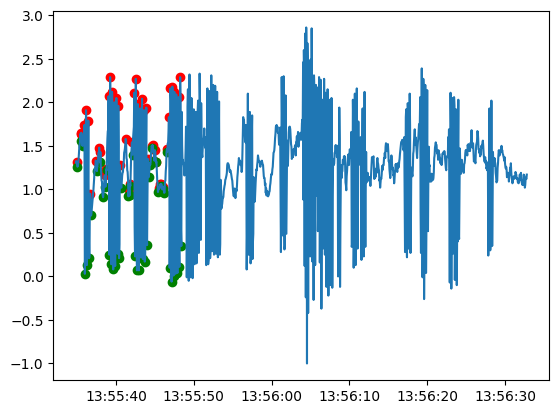

In [42]:
plt.plot(test.acc.DT[test.flInds[0]].values,test.acc.Z[test.
flInds[0]].values)

plt.scatter(test.acc.DT[pks[0:50]].values,
            test.acc.Z[pks[0:50]].values,c='r')
plt.scatter(test.acc.DT[troughs[0:50]].values,
            test.acc.Z[troughs[0:50]].values,c='g')

([<matplotlib.axis.XTick at 0x230b15ea520>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

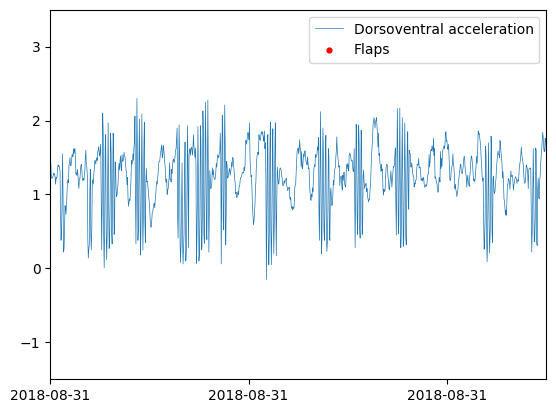

In [27]:
# import matplotlib.pyplot as plt

plt.plot(np.array(test.acc['DT']),np.array(test.acc['Z']),label='Dorsoventral acceleration',linewidth=.5)
plt.scatter(test.acc.DT[test.flight==1],test.acc.Z[test.flight==1],c='r',label='Flaps',s=12)
plt.legend()
plt.xlim(test.acc.DT[0],test.acc.DT[1000])
plt.ylim(-1.5,3.5)
plt.xticks(np.datetime_as_string(np.arange(test.acc.DT[0],test.acc.DT[1000],np.timedelta64(20,'s')),unit='s'))
# # plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)